# This is my fourth attempt at creating a model using sklearn alogithms

In this iteration of analysis we'll be looking at breaking out categorical varaibles and making them binary, and seeing if that makes our model more accurate. 

My last three attempts at this are below:

https://github.com/rileyrustad/CLCrawler/blob/master/First_Analysis.ipynb

https://github.com/rileyrustad/CLCrawler/blob/master/Second_Analysis.ipynb

https://github.com/rileyrustad/CLCrawler/blob/master/Third_Analysis.ipynb

#### Start with the Imports

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/Users/mac28/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Load the data from our JSON file. 
The data is stored as a dictionary of dictionaries in the json file. We store it that way beacause it's easy to add data to the existing master data file. Also, I haven't figured out how to get it in a database yet.

In [2]:
with open('/Users/mac28/CLCrawler/data/MasterApartmentData.json') as f:
    my_dict = json.load(f)
dframe = DataFrame(my_dict)

dframe = dframe.T
dframe.shape

(27391, 18)

## Clean up the data a bit
Right now the 'shared' and 'split' are included in number of bathrooms. If I were to convert that to a number I would consider a shared/split bathroom to be half or 0.5 of a bathroom.

In [3]:
dframe.bath = dframe.bath.replace('shared',0.5)
dframe.bath = dframe.bath.replace('split',0.5)

## Let's get a look at what the prices look like
To visualize it we need to get rid of null values. I haven't figured out the best way to clean this up yet. For now I'm going to drop any rows that have a null value, though I recognize that this is not a good analysis practice. We ended up dropping ~15% of data points. 

😬

Also there were some CRAZY outliers, and this analysis is focused on finding a model for apartments for the 99% of us that can't afford crazy extravigant apartments

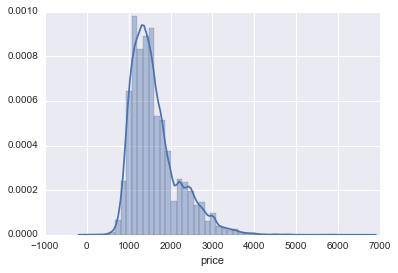

In [4]:
df = dframe[dframe.price < 10000][['bath','bed','feet','price']].dropna()
sns.distplot(df.price)

/Users/mac28/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


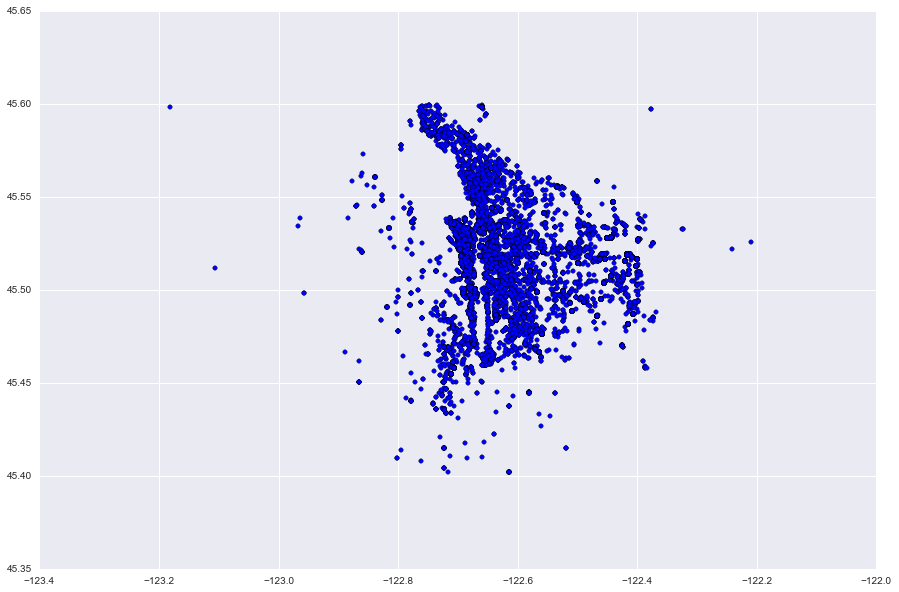

In [5]:
data = dframe[dframe.lat > 45.4][dframe.lat < 45.6][dframe.long < -122.0][dframe.long > -123.5]
plt.figure(figsize=(15,10))
plt.scatter(data = data, x = 'long',y='lat')


### It looks like Portland!!!
Let's cluster the data. Start by creating a list of [['lat','long'], ...]

In [6]:
XYdf = dframe[dframe.lat > 45.4][dframe.lat < 45.6][dframe.long < -122.0][dframe.long > -123.5]
data = [[XYdf['lat'][i],XYdf['long'][i]] for i in XYdf.index]



We'll use K Means Clustering because that's the clustering method I recently learned in class! There may be others that work better, but this is the tool that I know

In [9]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=40)
km.fit(data)
neighborhoods = km.cluster_centers_


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


'Note to Riley: come back and make it look pretty'

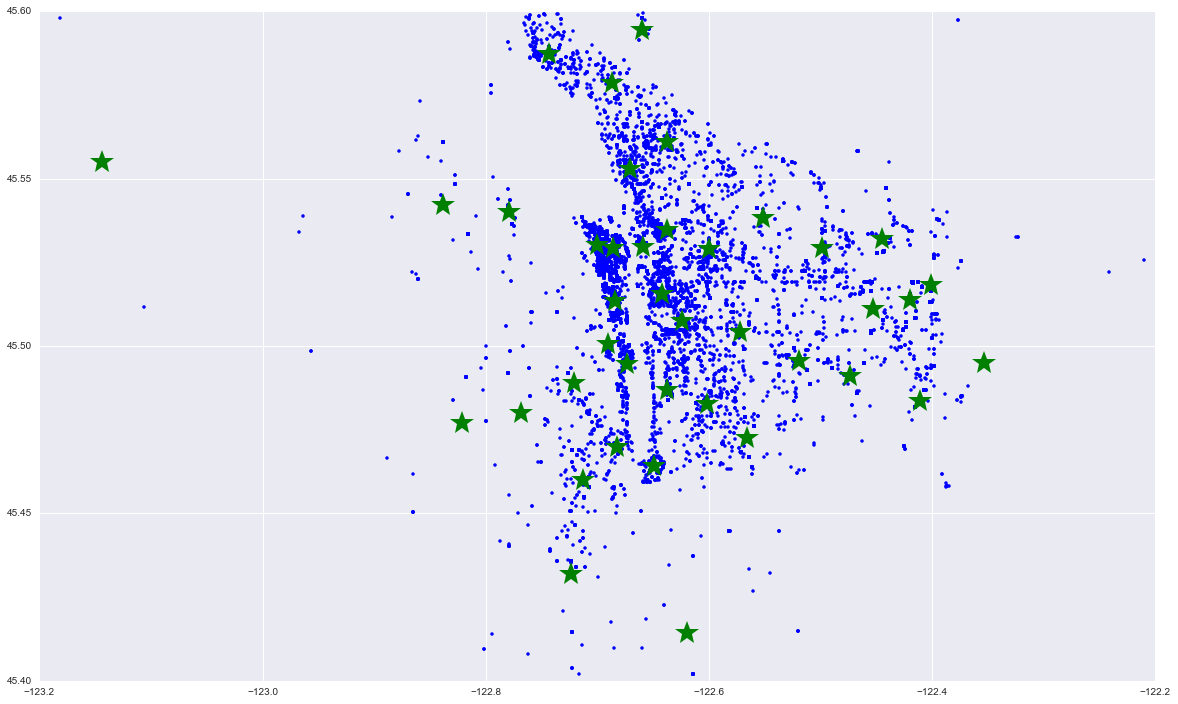

In [8]:
%pylab inline
figure(1,figsize=(20,12))
plot([row[1] for row in data],[row[0] for row in data],'b.')
for i in km.cluster_centers_:  
    plot(i[1],i[0], 'g*',ms=25)
'''Note to Riley: come back and make it look pretty'''

### We chose our neighborhoods!
I've found that every once in a while the centers end up in different points, but are fairly consistant. Now let's process our data points and figure out where the closest neighborhood center is to it!

In [10]:
neighborhoods = neighborhoods.tolist()
for i in enumerate(neighborhoods):
    i[1].append(i[0])
print neighborhoods

[[45.552123420408165, -122.67131269489796, 0], [45.51092562287105, -122.45307534793187, 1], [45.506688980830674, -122.62617021405751, 2], [45.51290160229575, -122.68343233254558, 3], [45.587227178666666, -122.743129376, 4], [45.52450939197531, -122.55208463888889, 5], [45.452784070281126, -122.71596119076305, 6], [45.47244749687109, -122.56570525907384, 7], [45.51805015181518, -122.50170698019802, 8], [45.54218268181818, -122.83868146363636, 9], [45.48445444117647, -122.40939808823529, 10], [45.532534597305386, -122.70121312874251, 11], [45.478594089908256, -122.67784825504587, 12], [45.57852603030303, -122.68672382386364, 13], [45.534753504540866, -122.63718108476287, 14], [45.486881816, -122.6372868544, 15], [45.529539962154296, -122.6856359297671, 16], [45.49200958955224, -122.7456509925373, 17], [45.51650509148265, -122.40908712513144, 18], [45.515484257077276, -122.64211889671002, 19], [45.539150457831326, -122.77935245783132, 20], [45.545689939759036, -122.59564720783132, 21], [4

Create a function that will label each point with a number coresponding to it's neighborhood

In [11]:
def clusterer(X, Y,neighborhoods):
    neighbors = []
    for i in neighborhoods:
        distance = ((i[0]-X)**2 + (i[1]-Y)**2)
        neighbors.append(distance)
    closest = min(neighbors)
    return neighbors.index(closest)

In [12]:
neighborhoodlist = []
for i in dframe.index:
    neighborhoodlist.append(clusterer(dframe['lat'][i],dframe['long'][i],neighborhoods))
dframe['neighborhood'] = neighborhoodlist


In [13]:
dframe

,bath,bed,cat,content,date,dog,feet,getphotos,hasmap,housingtype,lat,laundry,long,parking,price,smoking,time,wheelchair,neighborhood
5399866740,1,1,0,754,2016-01-12,0,750,8,0,apartment,NaN,w/d in unit,NaN,off-street parking,1400,NaN,12:22:07,NaN,0
5401772970,1,1,1,2632,2016-01-13,1,659,7,1,apartment,45.531,w/d in unit,-122.664,attached garage,1350,no smoking,16:24:11,wheelchair accessible,33
5402562933,1.5,NaN,0,1001,2016-01-14,0,1,2,1,apartment,45.5333,laundry on site,-122.709,carport,1500,no smoking,09:12:40,NaN,11
5402607488,1,2,0,2259,2016-01-14,0,936,12,1,condo,45.5328,w/d in unit,-122.699,attached garage,1995,NaN,09:36:16,NaN,11
5402822514,1,1,0,1110,2016-01-14,0,624,16,1,apartment,45.5053,w/d in unit,-122.618,street parking,1495,NaN,11:31:03,NaN,2
5402918870,2.5,3,0,1318,2016-01-14,0,1684,22,1,townhouse,45.602,w/d in unit,-122.667,attached garage,1800,no smoking,12:24:52,NaN,38
5403011764,1,1,1,1649,2016-01-14,1,750,14,1,apartment,45.5555,w/d hookups,-122.658,street parking,1340,NaN,13:19:56,NaN,0
5403019783,1,1,1,1324,2016-01-14,1,640,5,1,apartment,45.5198,laundry on site,-122.687,street parking,1095,no smoking,13:24:43,NaN,39
5403242242,1,0,1,2862,2016-01-14,1,NaN,12,1,apartment,45.5413,laundry on site,-122.676,street parking,1235,no smoking,15:54:38,NaN,0
5403320258,1.5,3,0,1598,2016-01-14,0,1200,17,1,house,45.4079,w/d in unit,-122.762,attached garage,1725,no smoking,16:58:11,wheelchair accessible,6


### Here's the new Part. We're breaking out the neighborhood values into their own columns. Now the algorithms can read them as categorical data rather than continuous data.

In [14]:
from sklearn import preprocessing
def CategoricalToBinary(dframe,column_name):
    le = preprocessing.LabelEncoder()
    listy = le.fit_transform(dframe[column_name])
    dframe[column_name] = listy
    unique = dframe[column_name].unique()
    serieslist = [list() for _ in xrange(len(unique))]
    
    
    for column, _ in enumerate(serieslist):
        for i, item in enumerate(dframe[column_name]):
            if item == column:
                serieslist[column].append(1)
            else:
                serieslist[column].append(0)
        dframe[column_name+str(column)] = serieslist[column]

   
    return dframe





In [15]:
pd.set_option('max_columns', 100)
dframe = CategoricalToBinary(dframe,'housingtype')
dframe = CategoricalToBinary(dframe,'parking')
dframe = CategoricalToBinary(dframe,'laundry')
dframe = CategoricalToBinary(dframe,'smoking')
dframe = CategoricalToBinary(dframe,'wheelchair')
dframe = CategoricalToBinary(dframe,'neighborhood')
dframe


/Users/mac28/anaconda/lib/python2.7/site-packages/numpy/lib/arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


,bath,bed,cat,content,date,dog,feet,getphotos,hasmap,housingtype,lat,laundry,long,parking,price,smoking,time,wheelchair,neighborhood,housingtype0,housingtype1,housingtype2,housingtype3,housingtype4,housingtype5,housingtype6,housingtype7,housingtype8,housingtype9,housingtype10,housingtype11,parking0,parking1,parking2,parking3,parking4,parking5,parking6,parking7,laundry0,laundry1,laundry2,laundry3,laundry4,laundry5,smoking0,smoking1,wheelchair0,wheelchair1,neighborhood0,neighborhood1,neighborhood2,neighborhood3,neighborhood4,neighborhood5,neighborhood6,neighborhood7,neighborhood8,neighborhood9,neighborhood10,neighborhood11,neighborhood12,neighborhood13,neighborhood14,neighborhood15,neighborhood16,neighborhood17,neighborhood18,neighborhood19,neighborhood20,neighborhood21,neighborhood22,neighborhood23,neighborhood24,neighborhood25,neighborhood26,neighborhood27,neighborhood28,neighborhood29,neighborhood30,neighborhood31,neighborhood32,neighborhood33,neighborhood34,neighborhood35,neighborhood36,neighborhood37,neighborhood38,neighborhood39
5399866740,1,1,0,754,2016-01-12,0,750,8,0,1,NaN,5,NaN,5,1400,0,12:22:07,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5401772970,1,1,1,2632,2016-01-13,1,659,7,1,1,45.531,5,-122.664,1,1350,1,16:24:11,1,33,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5402562933,1.5,NaN,0,1001,2016-01-14,0,1,2,1,1,45.5333,2,-122.709,2,1500,1,09:12:40,0,11,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5402607488,1,2,0,2259,2016-01-14,0,936,12,1,2,45.5328,5,-122.699,1,1995,0,09:36:16,0,11,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5402822514,1,1,0,1110,2016-01-14,0,624,16,1,1,45.5053,5,-122.618,6,1495,0,11:31:03,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5402918870,2.5,3,0,1318,2016-01-14,0,1684,22,1,11,45.602,5,-122.667,1,1800,1,12:24:52,0,38,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5403011764,1,1,1,1649,2016-01-14,1,750,14,1,1,45.5555,4,-122.658,6,1340,0,13:19:56,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5403019783,1,1,1,1324,2016-01-14,1,640,5,1,1,45.5198,2,-122.687,6,1095,1,13:24:43,0,39,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5403242242,1,0,1,2862,2016-01-14,1,NaN,12,1,1,45.5413,2,-122.676,6,1235,1,15:54:38,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5403320258,1.5,3,0,1598,2016-01-14,0,1200,17,1,6,45.4079,5,-122.762,1,1725,1,16:58:11,1,6,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [16]:
dframe = dframe.drop('date',1)
dframe = dframe.drop('housingtype',1)
dframe = dframe.drop('parking',1)
dframe = dframe.drop('laundry',1)
dframe = dframe.drop('smoking',1)
dframe = dframe.drop('wheelchair',1)
dframe = dframe.drop('neighborhood',1)
dframe = dframe.drop('time',1)




In [17]:
columns=list(dframe.columns)


In [18]:
from __future__ import division
print len(dframe)
df2 = dframe[dframe.price < 10000][columns].dropna()
print len(df2)
print len(df2)/len(dframe)

price = df2[['price']].values
columns.pop(columns.index('price'))
features = df2[columns].values

from sklearn.cross_validation import train_test_split
features_train, features_test, price_train, price_test = train_test_split(features, price, test_size=0.1, random_state=42)

27391
22164
0.80917089555


Ok, lets put it through Decision Tree!

## What about Random Forest?

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
reg = RandomForestRegressor()
reg = reg.fit(features_train, price_train)


/Users/mac28/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [ ]:
forest_pred = reg.predict(features_test)
forest_pred = np.array([[item] for item in forest_pred])

In [ ]:
print r2_score(forest_pred, price_test)
plt.scatter(forest_pred,price_test)


In [ ]:
df2['predictions'] = reg.predict(df2[columns])

In [ ]:
df2['predictions_diff'] = df2['predictions']-df2['price']

In [ ]:
sd = np.std(df2['predictions_diff'])
sns.kdeplot(df2['predictions_diff'][df2['predictions_diff']>-150][df2['predictions_diff']<150])
sns.plt.xlim(-150,150)

In [ ]:
data = df2[dframe.lat > 45.45][df2.lat < 45.6][df2.long < -122.4][df2.long > -122.8][df2['predictions_diff']>-150][df2['predictions_diff']<150]
plt.figure(figsize=(15,10))
plt.scatter(data = data, x = 'long',y='lat', c = 'predictions_diff',s=10,cmap='coolwarm')

In [ ]:
dframe

In [ ]:
print np.mean([1,2,34,np.nan])

In [ ]:
def averager(dframe):
    dframe = dframe.T
    dframe.dropna()
    averages = {}
    for listing in dframe:
        try:
            key = str(dframe[listing]['bed'])+','+str(dframe[listing]['bath'])+','+str(dframe[listing]['neighborhood'])+','+str(dframe[listing]['feet']-dframe[listing]['feet']%50)
            if key not in averages:
                averages[key] = {'average_list':[dframe[listing]['price']], 'average':0}
            elif key in averages:
                averages[key]['average_list'].append(dframe[listing]['price'])
        except TypeError:
            continue
    for entry in averages:
        averages[entry]['average'] = np.mean(averages[entry]['average_list'])
    return averages
            
        
            
            
        

In [ ]:
averages = averager(dframe)
print averages

In [ ]:
dframe['averages']= averages[str(dframe['bed'])+','+str(dframe['bath'])+','+str(dframe['neighborhood'])+','+str(dframe['feet']-dframe['feet']%50)]

In [ ]:
dframe.T


Wow! up to .87! That's our best yet! What if we add more trees???

In [ ]:
reg = RandomForestRegressor(n_estimators = 100)
reg = reg.fit(features_train, price_train)

In [ ]:
forest_pred = reg.predict(features_test)
forest_pred = np.array([[item] for item in forest_pred])

In [ ]:
print r2_score(forest_pred, price_test)
print plt.scatter(pred,price_test)

In [36]:
from sklearn.tree import DecisionTreeRegressor
reg = DecisionTreeRegressor(max_depth = 5)
reg.fit(features_train, price_train)
print len(features_train[0])
columns = [str(x) for x in columns]
print columns
from sklearn.tree import export_graphviz
export_graphviz(reg,feature_names=columns)

80
['bath', 'bed', 'cat', 'content', 'dog', 'feet', 'getphotos', 'hasmap', 'lat', 'long', 'housingtype0', 'housingtype1', 'housingtype2', 'housingtype3', 'housingtype4', 'housingtype5', 'housingtype6', 'housingtype7', 'housingtype8', 'housingtype9', 'housingtype10', 'housingtype11', 'parking0', 'parking1', 'parking2', 'parking3', 'parking4', 'parking5', 'parking6', 'parking7', 'laundry0', 'laundry1', 'laundry2', 'laundry3', 'laundry4', 'laundry5', 'smoking0', 'smoking1', 'wheelchair0', 'wheelchair1', 'neighborhood0', 'neighborhood1', 'neighborhood2', 'neighborhood3', 'neighborhood4', 'neighborhood5', 'neighborhood6', 'neighborhood7', 'neighborhood8', 'neighborhood9', 'neighborhood10', 'neighborhood11', 'neighborhood12', 'neighborhood13', 'neighborhood14', 'neighborhood15', 'neighborhood16', 'neighborhood17', 'neighborhood18', 'neighborhood19', 'neighborhood20', 'neighborhood21', 'neighborhood22', 'neighborhood23', 'neighborhood24', 'neighborhood25', 'neighborhood26', 'neighborhood27', 

Up to .88!

So what is our goal now? I'd like to see if adjusting the number of neighborhoods increases the accuracy. same for the affect with the number of trees

In [ ]:
def neighborhood_optimizer(dframe,neighborhood_number_range, counter_num):
    XYdf = dframe[dframe.lat > 45.4][dframe.lat < 45.6][dframe.long < -122.0][dframe.long > -123.5]
    data = [[XYdf['lat'][i],XYdf['long'][i]] for i in XYdf.index]
    r2_dict = []
    for i in neighborhood_number_range:
        counter = counter_num
        average_accuracy_list = []
        while counter > 0:
            km = KMeans(n_clusters=i)
            km.fit(data)
            neighborhoods = km.cluster_centers_
            neighborhoods = neighborhoods.tolist()
            for x in enumerate(neighborhoods):
                x[1].append(x[0])
            neighborhoodlist = []
            for z in dframe.index:
                neighborhoodlist.append(clusterer(dframe['lat'][z],dframe['long'][z],neighborhoods))
            dframecopy = dframe.copy()
            dframecopy['neighborhood'] = Series((neighborhoodlist), index=dframe.index)
            df2 = dframecopy[dframe.price < 10000][['bath','bed','feet','dog','cat','content','getphotos', 'hasmap', 'price','neighborhood']].dropna()
            features = df2[['bath','bed','feet','dog','cat','content','getphotos', 'hasmap', 'neighborhood']].values
            price = df2[['price']].values
            features_train, features_test, price_train, price_test = train_test_split(features, price, test_size=0.1)
            reg = RandomForestRegressor()
            reg = reg.fit(features_train, price_train)
            forest_pred = reg.predict(features_test)
            forest_pred = np.array([[item] for item in forest_pred])
            counter -= 1
            average_accuracy_list.append(r2_score(forest_pred, price_test))
        total = 0
        for entry in average_accuracy_list:
            total += entry
        r2_accuracy = total/len(average_accuracy_list)
        r2_dict.append((i,r2_accuracy))
    print r2_dict
    return r2_dict

In [ ]:
neighborhood_number_range = [i for _,i in enumerate(range(2,31,2))]
neighborhood_number_range

In [ ]:
r2_dict = neighborhood_optimizer(dframe,neighborhood_number_range,10)

In [ ]:
r2_dict[:][0]

In [ ]:
plt.scatter([x[0] for x in r2_dict],[x[1] for x in r2_dict])

Looks like the optimum is right around 10 or 11, and then starts to drop off. Let's get a little more granular and look at a smaller range

In [ ]:
neighborhood_number_range = [i for _,i in enumerate(range(7,15))]
neighborhood_number_range

In [ ]:
r2_dict = neighborhood_optimizer(dframe,neighborhood_number_range,10)

In [ ]:
print r2_dict
plt.scatter([x[0] for x in r2_dict],[x[1] for x in r2_dict])

Trying a few times, it looks like 10, 11 and 12 get the best results at ~.85. Of course, we'll need to redo some of these optomizations after we properly process our data. Hopefully we'll see some more consistency then too.

In [ ]:
r2_dict = neighborhood_optimizer(dframe,[10,11,12],25)

Note #1 to Riley: (From Last time) Perhaps look into another regressor? see if there's one that's inherantly better at this kind of thing.

Note #2 to Riley: Figure out how to process data so that you don't have to drop null values

Note #3 to Riley: convert categorical data into binary

Note #4 to Riley: I wonder if increasing the number of neighborhoods would become more accurate as we collect more data? like you could create a bunch of little accurate models instead of a bunch of bigger ones.

Learned: If you plan on using Decision Tree/Random Forest from SKLearn, make sure you collect your discrete variables in separate columns and make them binary yes or no(0 or 1).